# Cleaning Housing and Crime Datasets

## Import Dependencies and Read In Files

In [1]:
#import necessary dependencies
import pandas as pd
import numpy as np
from sodapy import Socrata
import time
import kaggle
from matplotlib import pyplot as plt

# Import API token
from config import app_token

# SQL database connnection imports
from config import password
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# read in csvs
raw_house_df = pd.read_csv('Resources/austinHousingData.csv')
raw_crime_df = pd.read_csv('Resources/Crime_Reports.csv')

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## API Calls

In [226]:
# #API call to get crime data - Takes about 13 minutes to run
# start = time.perf_counter()
# # create client variable with parameters
# client = Socrata('data.austintexas.gov',
#                  app_token=app_token)
# # retrieve data; look into limit ?get_all?
# results = client.get("fdj4-gpfu", limit=3000000)
# # Convert to pandas DataFrame
# raw_crime_df = pd.DataFrame.from_records(results)

# end = time.perf_counter()
# print(f'{end-start}')

476.3087814170012


In [ ]:
# #API call to get housing data
# kaggle.api.authenticate()
# kaggle.api.dataset_download_file('ericpierce/austinhousingprices', file_name='austinHousingData.csv',  path='Resources/')
# raw_house_df = pd.read_csv('Resources/austinHousingData.csv.zip')

## Housing Data

In [3]:
# preview df 
raw_house_df.head()

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage
0,111373431,pflugerville,14424 Lake Victor Dr,78660,"14424 Lake Victor Dr, Pflugerville, TX 78660 i...",30.430632,-97.663078,1.98,2,True,...,1,1,1.266667,2.666667,1063,14,3.0,4,2,111373431_ffce26843283d3365c11d81b8e6bdc6f-p_f...
1,120900430,pflugerville,1104 Strickling Dr,78660,Absolutely GORGEOUS 4 Bedroom home with 2 full...,30.432673,-97.661697,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,4,1,120900430_8255c127be8dcf0a1a18b7563d987088-p_f...
2,2084491383,pflugerville,1408 Fort Dessau Rd,78660,Under construction - estimated completion in A...,30.409748,-97.639771,1.98,0,True,...,1,1,1.200000,3.000000,1108,14,2.0,3,1,2084491383_a2ad649e1a7a098111dcea084a11c855-p_...
3,120901374,pflugerville,1025 Strickling Dr,78660,Absolutely darling one story home in charming ...,30.432112,-97.661659,1.98,2,True,...,1,1,1.400000,2.666667,1063,14,2.0,3,1,120901374_b469367a619da85b1f5ceb69b675d88e-p_f...
4,60134862,pflugerville,15005 Donna Jane Loop,78660,Brimming with appeal & warm livability! Sleek ...,30.437368,-97.656860,1.98,0,True,...,1,1,1.133333,4.000000,1223,14,3.0,3,2,60134862_b1a48a3df3f111e005bb913873e98ce2-p_f.jpg


In [4]:
#check row and column count of df 
raw_house_df.shape

(15171, 47)

In [5]:
#check dtypes
raw_house_df.dtypes

zpid                            int64
city                           object
streetAddress                  object
zipcode                         int64
description                    object
latitude                      float64
longitude                     float64
propertyTaxRate               float64
garageSpaces                    int64
hasAssociation                   bool
hasCooling                       bool
hasGarage                        bool
hasHeating                       bool
hasSpa                           bool
hasView                          bool
homeType                       object
parkingSpaces                   int64
yearBuilt                       int64
latestPrice                   float64
numPriceChanges                 int64
latest_saledate                object
latest_salemonth                int64
latest_saleyear                 int64
latestPriceSource              object
numOfPhotos                     int64
numOfAccessibilityFeatures      int64
numOfApplian

In [6]:
#Drop columns that are mostly 0 or not as applicable to analysis
house_df= raw_house_df.drop(['numOfAccessibilityFeatures','latestPriceSource','numOfPhotos','numOfSecurityFeatures','numOfPatioAndPorchFeatures','numOfWaterfrontFeatures', 'numOfWindowFeatures','numOfCommunityFeatures'], axis = 1)
house_df.shape

(15171, 39)

In [7]:
#what are the homeTypes? normalize=True provides the percentage
#With normalize set to True, returns the relative frequency by dividing all values by the sum of values.
house_df['homeType'].value_counts(normalize=True)


Single Family            0.938699
Condo                    0.030980
Townhouse                0.011469
Multiple Occupancy       0.006328
Vacant Land              0.005471
Residential              0.002439
Apartment                0.002439
Mobile / Manufactured    0.001121
MultiFamily              0.000659
Other                    0.000395
Name: homeType, dtype: float64

In [8]:
# Single Family makes up most of the data, we are going to drop the rest
house_df = house_df.loc[((house_df['homeType'] == 'Single Family'))]
# Only Austin houses
austin_house_df=house_df.loc[house_df['city'] == 'austin']
#what years were the houses sold? 
austin_house_df['latest_saleyear'].unique()

array([2018, 2020, 2019, 2021])

In [9]:
#Earliest sell date
austin_house_df['latest_saledate'].min()

'2018-01-22'

In [10]:
#Latest sale date
austin_house_df['latest_saledate'].max()

'2021-01-30'

In [19]:
#Since not a lot of data available for 2021, will drop that year
austin_house_df=austin_house_df.loc[austin_house_df['latest_saleyear'] != 2021]


In [20]:
#Find zicpdes that sold 3 or less houses in 2018-2020, will not include 2021 since only 1 month made it into the dataset
austin2018_df=austin_house_df[austin_house_df['latest_saleyear']==2018]
austin2018_grouped_df=austin2018_df.groupby(['zipcode']).count().sort_values(by="city")
to_drop_2018=austin2018_grouped_df[austin2018_grouped_df['city']<=3].index.tolist()
#Find zipcodes that sold 3 or less houses in 2019
austin2019_df=austin_house_df[austin_house_df['latest_saleyear']==2019]
austin2019_grouped_df=austin2019_df.groupby(['zipcode']).count().sort_values(by="city")
to_drop_2019=austin2019_grouped_df[austin2019_grouped_df['city']<=3].index.tolist()
#Find zipcodes that sold 3 or less houses in 2020
austin2020_df=austin_house_df[austin_house_df['latest_saleyear']==2020]
austin2020_grouped_df=austin2020_df.groupby(['zipcode']).count().sort_values(by="city")
to_drop_2020=austin2020_grouped_df[austin2020_grouped_df['city']<=3].index.tolist()
#Combine zipcodes to drop
to_drop_zips=to_drop_2018+to_drop_2019+to_drop_2020
len(to_drop_zips)

10

In [21]:
#Drop zipcodes from DF
austin_house_df= austin_house_df[austin_house_df.zipcode.isin(to_drop_zips)==False]
austin_house_df.shape

(13999, 39)

In [22]:
#check if there are null values 
austin_house_df[austin_house_df.isnull().any(axis = 1)]

,zpid,city,streetAddress,zipcode,description,latitude,longitude,propertyTaxRate,garageSpaces,hasAssociation,...,numOfMiddleSchools,numOfHighSchools,avgSchoolDistance,avgSchoolRating,avgSchoolSize,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,homeImage


In [23]:
#create a df with the relevant Austin housing information
df_housing=austin_house_df[['zipcode', 'propertyTaxRate',
       'yearBuilt', 'latestPrice',
       'latest_saleyear', 'lotSizeSqFt', 'livingAreaSqFt', 'numOfBathrooms', 'numOfBedrooms',
       'numOfStories',"avgSchoolRating","numOfPrimarySchools",
                   "numOfElementarySchools","numOfMiddleSchools","numOfHighSchools"]].copy()

In [24]:
#Sort by bathroom number
sorted_df=df_housing.sort_values(by='numOfBathrooms',ascending=False)
sorted_df.head(10)

,zipcode,propertyTaxRate,yearBuilt,latestPrice,latest_saleyear,lotSizeSqFt,livingAreaSqFt,numOfBathrooms,numOfBedrooms,numOfStories,avgSchoolRating
2838,78731,1.98,1967,745000.0,2020,10236.0,2137.0,27.0,4,1,7.000000
2316,78732,1.98,2016,13500000.0,2018,710899.2,15394.0,13.0,6,1,8.333333
184,78732,1.98,2014,4100000.0,2020,172497.6,9866.0,10.0,6,2,8.333333
2547,78733,1.98,2014,2795000.0,2019,82328.4,11581.0,10.0,7,3,8.000000
375,78732,1.98,2014,4950000.0,2018,116740.8,13731.0,10.0,5,2,8.333333
5328,78735,1.98,2003,2700000.0,2018,138956.4,14091.0,10.0,6,3,5.666667
613,78733,1.98,2007,2750000.0,2018,43560.0,10611.0,10.0,6,2,8.000000
4753,78735,1.98,1999,2190000.0,2019,199940.4,11871.0,9.0,6,3,5.666667
4920,78735,1.98,2002,2765000.0,2018,192099.6,7142.0,9.0,6,2,5.666667
193,78732,1.98,2012,5474997.0,2019,116305.2,7740.0,8.0,6,2,8.333333


In [25]:
#Drop the bathroom outlier
df_housing.drop(2838,axis=0,inplace=True)

In [26]:
#convert clean_df to csv 
df_housing.to_csv(r'Resources/HousingData_clean.csv')

## Crime Data

In [125]:
#code to view all rows
pd.set_option("display.max_rows", None)
#preview data
raw_crime_df.sample(5)

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
138569,20101660345,THEFT,600,N,06/15/2010 06:41:00 AM,06/15/2010,641.0,06/15/2010 07:40:00 AM,06/15/2010,740.0,...,21.13,C,09/22/2010,23H,Theft,3136556.0,3136556.0,30.317089,-97.670977,"(30.31708928, -97.67097672)"
1660817,20092350696,LIQUOR LAW VIOLATION/OTHER,2208,N,08/23/2009 06:40:00 AM,08/23/2009,640.0,08/23/2009 06:40:00 AM,08/23/2009,640.0,...,11.00,C,08/31/2009,NaN,NaN,3116774.0,3116774.0,30.265947,-97.735066,"(30.26594692, -97.73506592)"
1054957,20145052236,THEFT,600,N,11/26/2014 03:47:00 AM,11/26/2014,347.0,11/26/2014 08:10:00 AM,11/26/2014,810.0,...,6.00,N,12/11/2014,23H,Theft,3114232.0,3114232.0,30.294899,-97.742343,"(30.29489858, -97.74234315)"
1192394,20128000956,BURGLARY OF VEHICLE,601,N,05/05/2012 08:30:00 PM,05/05/2012,2030.0,05/15/2012 12:04:00 PM,05/15/2012,1204.0,...,324.00,N,05/18/2012,23F,Theft,3114413.0,3114413.0,30.387691,-97.739275,"(30.38769108, -97.73927549)"
2361183,2016801597,CRIMINAL MISCHIEF,1400,N,03/20/2016 08:28:00 PM,03/20/2016,2028.0,03/20/2016 08:28:00 PM,03/20/2016,2028.0,...,400.00,N,03/31/2016,NaN,NaN,3124962.0,3124962.0,30.334662,-97.707253,"(30.33466153, -97.70725341)"


In [27]:
#removing spaces in column names 
raw_crime_df.columns = raw_crime_df.columns.str.replace(' ','_')
#create a year column for occurred date 
raw_crime_df['year'] = pd.DatetimeIndex(raw_crime_df['Occurred_Date']).year
#Rename zipcode column to marge both datasets
raw_crime_df.rename(columns={"Zip_Code":"zipcode"}, inplace=True)

In [45]:
#filter dataframe to be between 2018-2021
filtered_crime_df = raw_crime_df[raw_crime_df['year']>=2018]
filtered_crime_df = filtered_crime_df[filtered_crime_df['year']<=2020]
filtered_crime_df.shape

(311514, 28)

In [128]:
#check null values
#do we want to drop null values or do we want to drop the columns? 
filtered_crime_df.isnull().sum(axis = 0)

Incident_Number                     0
Highest_Offense_Description         0
Highest_Offense_Code                0
Family_Violence                     0
Occurred_Date_Time                  0
Occurred_Date                       0
Occurred_Time                       0
Report_Date_Time                    0
Report_Date                         0
Report_Time                         0
Location_Type                    1127
Address                             0
zipcode                          2682
Council_District                 4472
APD_Sector                       1692
APD_District                     1775
PRA                              2187
Census_Tract                     3747
Clearance_Status                47729
Clearance_Date                  47739
UCR_Category                   249545
Category_Description           249545
X-coordinate                     2080
Y-coordinate                     2080
Latitude                         7493
Longitude                        7493
Location    

In [129]:
#drop unneccessary columns for our analysis 
dropped_col_df= filtered_crime_df.drop(["Council_District","APD_Sector","APD_District","PRA","Occurred_Time","Report_Time"],axis = 1)
dropped_col_df.shape

(405119, 22)

In [130]:
#dropping nulls of important columns -- dropping latitude will remove rape occurances 
clean_df = dropped_col_df.dropna(axis=0, subset=["Location_Type","zipcode","Census_Tract"
                                           ,"Latitude"])


In [131]:
#replacing nulls for UCR_Category with zero 
clean_df[["UCR_Category"]] = clean_df[["UCR_Category"]].fillna('0')
#replacing nulls with "None"
clean_df[["Category_Description"]] = clean_df[["Category_Description"]].fillna('None')
#replacing nulls with "U" for unkown 
clean_df[["Clearance_Status"]] = clean_df[["Clearance_Status"]].fillna('U')
#replacing nulls with a random date so its obvious on visualizaitons 
clean_df[["Clearance_Date"]] = clean_df[["Clearance_Date"]].fillna('01/01/1888')

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [132]:
#convert occurred date time to datetime dtype
clean_df['Occurred_Date_Time'] =  pd.to_datetime(clean_df['Occurred_Date_Time'])
#create an hour column for the ocurred time
clean_df['hour'] = pd.DatetimeIndex(clean_df['Occurred_Date_Time']).hour
clean_df['hour'].head()


/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1     22
5     22
6     14
7     12
10    17
Name: hour, dtype: int64

In [133]:
#divide into time buckets
clean_df['hour_category']=pd.cut(clean_df['hour'],
    [0,12,18,21,23],
        labels=['Morning','Afternoon','Evening','Night'],
        include_lowest=True)

/Users/nayely/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [134]:
## Count of crime per zipcode for 2018-2021
zipcode_grouped_df = clean_df.groupby(['zipcode']).count()
zipcode_crimecount_df=zipcode_grouped_df['Highest_Offense_Code'].to_frame()
zipcode_crimecount_df.rename(columns={'Highest_Offense_Code':'Count_Of_Crimes_Per_Zip'}, inplace=True)
# Calculating Percentage of Crime Count per ZipCode
zipcode_crimecount_df['Percentage_Of_Total_Crime'] = (zipcode_crimecount_df['Count_Of_Crimes_Per_Zip'] / 
                  zipcode_crimecount_df['Count_Of_Crimes_Per_Zip'].sum()) * 100
  
# Show the dataframe
zipcode_crimecount_df.sort_values(by=['Count_Of_Crimes_Per_Zip'], ascending=False)

,Count_Of_Crimes_Per_Zip,Percentage_Of_Total_Crime
zipcode,,
78741.0,31435,7.957664
78753.0,31072,7.865772
78758.0,30893,7.820458
78701.0,25870,6.548903
78704.0,25750,6.518525
78745.0,23251,5.885912
78723.0,21554,5.456322
78744.0,21305,5.393289
78702.0,17207,4.355894


In [56]:
#Sum offenses with a value of 0.0001 or higher
zipcode_crimecount_df[zipcode_crimecount_df['Percentage_Of_Total_Crime'] <= 0.9].sum()
#


Count_Of_Crimes_Per_Zip      34832.000000
Percentage_Of_Total_Crime        8.817603
dtype: float64

In [57]:
#Sum offenses with a value of 0.0001 or higher
zipcode_crimecount_df[zipcode_crimecount_df['Percentage_Of_Total_Crime'] <= 4].sum()
#mediano

Count_Of_Crimes_Per_Zip      166691.000000
Percentage_Of_Total_Crime        42.197262
dtype: float64

In [135]:
#Cluster count of crimes in levels
zipcode_crimecount_df['Percentage_Of_Total_Crime']=pd.cut(zipcode_crimecount_df['Percentage_Of_Total_Crime'],
    [0,.9,4,8],
        labels=['Low_Crime','Medium_Crime','High_Crime'],
        include_lowest=True)
zipcode_crimecount_df.rename(columns={"Percentage_Of_Total_Crime":"Crime_Level"}, inplace=True)
# Show the dataframe
sorted_zip_df=zipcode_crimecount_df.sort_values(by=['Count_Of_Crimes_Per_Zip'], ascending=False)
sorted_zip_df.head(10)

,Count_Of_Crimes_Per_Zip,Crime_Level
zipcode,,
78741.0,31435,High_Crime
78753.0,31072,High_Crime
78758.0,30893,High_Crime
78701.0,25870,High_Crime
78704.0,25750,High_Crime
78745.0,23251,High_Crime
78723.0,21554,High_Crime
78744.0,21305,High_Crime
78702.0,17207,High_Crime


In [138]:
group_df = clean_df.groupby(['zipcode','hour_category']).count()
dfp = group_df.pivot_table(index='zipcode', columns='hour_category', values=['Incident_Number'], aggfunc='sum')
dfp.head()
dfp.columns = dfp.columns.droplevel(0) #remove amount
dfp.columns.name = None               #remove categories
dfp.head()

,Morning,Afternoon,Evening,Night
zipcode,,,,
78610.0,10,8,3,3
78612.0,1,0,1,0
78613.0,642,806,366,126
78616.0,1,0,0,0
78617.0,1470,977,604,366


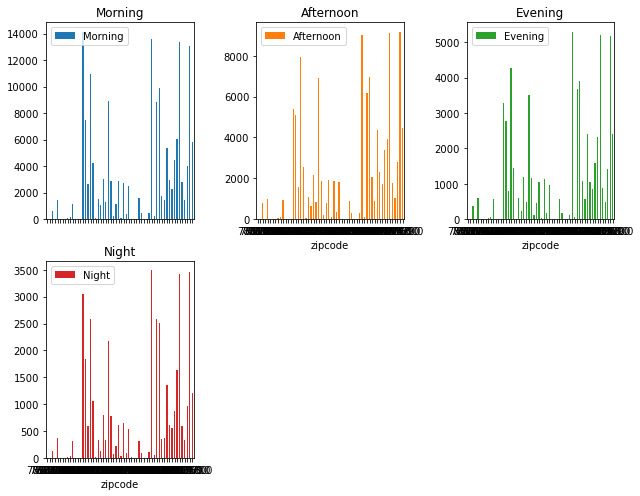

In [139]:
#Plot table
dfp.plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(2, 3))
plt.tight_layout()

In [140]:
#convert clean_df to csv 
clean_df.to_csv(r'Resources/2018To2020CrimeData_clean.csv')

## Export to SQL

In [ ]:
#set parameters for sql database
params = {"host": "localhost", "user": "postgres", "password": password, "port": 5432}

In [ ]:
#create MyDB class
class MyDB(object):
    def __init__(self):
        self.params = params
    
    #create a function to create a new database in sql
    def create_new_db(self, newdb):
        user, host, port = self.params['user'], self.params['host'], self.params['port']
        pw = self.params['password']
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(user, pw, host, port, newdb)
        
        self.engine = create_engine(url, client_encoding='utf8')
        if not database_exists(self.engine.url):
            create_database(self.engine.url)
    
    #create a function to export crime data to sql
    def df1postgres(self, df):
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(params['user'], params['password'], params['host'], params['port'], 'test') #name of db
        conn = create_engine(url)
        df.to_sql(name='crime_data', con=conn, if_exists='replace', index=False, chunksize=100)
    
    #create a function to export housing data to sql
    def df2postgres(self, df):
        url = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(params['user'], params['password'], params['host'], params['port'], 'test') #name of db
        conn = create_engine(url)
        df.to_sql(name='housing_data', con=conn, if_exists='replace', index=False, chunksize=10)
        
        return conn

In [ ]:
db = MyDB()
db.create_new_db('test') #name of db

In [ ]:
#Crime dataframe
con1 = db.df1postgres(crime_data)

#Crime by zipcode dataframe
con2 = db.df2postgres(zipcode_crimecount_df)

#Housing dataframe
con3 = db.df2postgres(clean_df)

#create connection 
conn = psycopg2.connect(dbname='test', user=params['user'], password=password, host=params['host'])

# check if connection to import crime data works
# crime_df = pd.read_sql_query('select * from "crime_data" limit 1',con=conn) 

# check if connection to import housing data works
# housing_df = pd.read_sql_query('select * from "housing_data" limit 1',con=conn) 

#insert sql query to merge crime and housing dataframe before importing to jupyter notebook

#close connection
conn.close()